3,4)

In [68]:
#ENV

from enum import IntEnum
from typing import Tuple, Optional, List
from gym import Env, spaces
from gym.utils import seeding
from gym.envs.registration import register
import random


def register_env() -> None:
    """Register custom gym environment so that we can use `gym.make()`

    In your main file, call this function before using `gym.make()` to use the Four Rooms environment.
        register_env()
        env = gym.make('FourRooms-v0')

    Note: the max_episode_steps option controls the time limit of the environment.
    You can remove the argument to make FourRooms run without a timeout.
    """
    register(id="FourRooms-v0", entry_point="env:FourRoomsEnv", max_episode_steps=459)


class Action(IntEnum):
    """Action"""

    LEFT = 0
    DOWN = 1
    RIGHT = 2
    UP = 3


def actions_to_dxdy(action: Action) -> Tuple[int, int]:
    """
    Helper function to map action to changes in x and y coordinates
    Args:
        action (Action): taken action
    Returns:
        dxdy (Tuple[int, int]): Change in x and y coordinates
    """
    mapping = {
        Action.LEFT: (-1, 0),
        Action.DOWN: (0, -1),
        Action.RIGHT: (1, 0),
        Action.UP: (0, 1),
    }
    return mapping[action]


class FourRoomsEnv(Env):
    """Four Rooms gym environment.

    This is a minimal example of how to create a custom gym environment. By conforming to the Gym API, you can use the same `generate_episode()` function for both Blackjack and Four Rooms envs.
    """

    def __init__(self, goal_pos=(10, 10)) -> None:
        self.rows = 11
        self.cols = 11
        self.max_steps = 459  # Maximum steps per episode
        self.current_step = 0  # Initialize step counter

        # Coordinate system is (x, y) where x is the horizontal and y is the vertical direction
        self.walls = [
            (0, 5),
            (2, 5),
            (3, 5),
            (4, 5),
            (5, 0),
            (5, 2),
            (5, 3),
            (5, 4),
            (5, 5),
            (5, 6),
            (5, 7),
            (5, 9),
            (5, 10),
            (6, 4),
            (7, 4),
            (9, 4),
            (10, 4),
        ]

        self.start_pos = (0, 0)
        self.goal_pos = goal_pos
        self.agent_pos = None

        self.action_space = spaces.Discrete(len(Action))
        self.observation_space = spaces.Tuple(
            (spaces.Discrete(self.rows), spaces.Discrete(self.cols))
        )
    def noise(self):

        r = random.random()
        if r <= 0.1:
            return 1  # denotes perpendicular direction 1
        elif r >= 0.9:
            return 2  # denotes perpendicular direction 2
        else:
            return 0  # denotes normal direction

    def seed(self, seed: Optional[int] = None) -> List[int]:
        """Fix seed of environment

        In order to make the environment completely reproducible, call this function and seed the action space as well.
            env = gym.make(...)
            env.seed(seed)
            env.action_space.seed(seed)

        This function does not need to be used for this assignment, it is given only for reference.
        """

        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def reset(self) -> Tuple[int, int]:
        self.current_step = 0  # Reset step counter
        """Reset agent to the starting position.

        Returns:
            observation (Tuple[int,int]): returns the initial observation
        """
        self.agent_pos = self.start_pos

        return self.agent_pos

    def step(self, action: Action) -> Tuple[Tuple[int, int], float, bool, dict]:
        """Take one step in the environment.

        Takes in an action and returns the (next state, reward, done, info).
        See https://github.com/openai/gym/blob/master/gym/core.py#L42-L58 foand r more info.

        Args:
            action (Action): an action provided by the agent

        Returns:
            observation (object): agent's observation after taking one step in environment (this would be the next state s')
            reward (float) : reward for this transition
            done (bool): whether the episode has ended, in which case further step() calls will return undefined results
            info (dict): contains auxiliary diagnostic information (helpful for debugging, and sometimes learning). Not used in this assignment.
        """
        self.current_step += 1  # Increment step counter

        # Check if goal was reached
        if self.agent_pos == self.goal_pos:
            done = True
            reward = 1.0
        else:
            done = False
            reward = 0.0

        # TODO modify action_taken so that 10% of the time, the action_taken is perpendicular to action (there are 2 perpendicular actions for each action).
        # You can reuse your code from ex0

        n = self.noise()

        # Determines what action to take based on input action and noise
        if action == Action.UP:
            if n == 1:
                action_taken = Action.LEFT
            elif n == 2:
                action_taken = Action.RIGHT
            else:
                action_taken = Action.UP

        if action == Action.LEFT:
            if n == 1:
                action_taken = Action.DOWN
            elif n == 2:
                action_taken = Action.UP
            else:
                action_taken = Action.LEFT

        if action == Action.RIGHT:
            if n == 1:
                action_taken = Action.UP
            elif n == 2:
                action_taken = Action.DOWN
            else:
                action_taken = Action.RIGHT

        if action == Action.DOWN:
            if n == 1:
                action_taken = Action.RIGHT
            elif n == 2:
                action_taken = Action.LEFT
            else:
                action_taken = Action.DOWN
        # Check if maximum number of steps is reached
        if self.current_step >= self.max_steps:
            done = True  # End the episode
        else:
            done = self.agent_pos == self.goal_pos
        # TODO calculate the next position using actions_to_dxdy()
        # You can reuse your code from ex0
        move = actions_to_dxdy(action_taken)
        next_pos = (self.agent_pos[0] + move[0], self.agent_pos[1] + move[1])

        # TODO check if next position is feasible
        # If the next position is a wall or out of bounds, stay at current position
        # Set self.agent_pos
        if next_pos in self.walls:  # If next state is a wall, keep current state
            pass
        elif (next_pos[0] < 0) or (next_pos[0] > 10):  # If x coordinate is out of bounds, keep current state
            pass
        elif (next_pos[1] < 0) or (next_pos[1] > 10):  # If y coordinate is out of bounds, keep current state
            pass
        else:
            self.agent_pos = next_pos

        return self.agent_pos, reward, done, {}





In [69]:
# policy.py
import numpy as np
from collections import defaultdict
from typing import Callable, Tuple


def default_blackjack_policy(state: Tuple[int, int, bool]) -> int:
    """default_blackjack_policy.

    Returns sticking on 20 or 21 and hit otherwise

    Args:
        state: the current state
    """
    if state[0] in [20, 21]:
        return 0
    else:
        return 1


def create_blackjack_policy(Q: defaultdict) -> Callable:
    """Creates an initial blackjack policy from default_blackjack_policy but updates policy using Q values.

    A policy is represented as a function here because the policies are simple. More complex policies can be represented using classes.

    Args:
        Q (defaultdict): current Q-values
    Returns:
        get_action (Callable): Takes a state as input and outputs an action
    """

    def get_action(state: Tuple) -> int:
        # If state was never seen before, use initial blackjack policy
        if state not in Q.keys():
            return default_blackjack_policy(state)
        else:
            # Choose deterministic greedy action
            chosen_action = np.argmax(Q[state]).item()
            return chosen_action

    return get_action


def create_epsilon_policy(Q: defaultdict, epsilon: float) -> Callable:
    """Creates an epsilon soft policy from Q values.

    A policy is represented as a function here because the policies are simple. More complex policies can be represented using classes.

    Args:
        Q (defaultdict): current Q-values
        epsilon (float): softness parameter
    Returns:
        get_action (Callable): Takes a state as input and outputs an action
    """


    def get_action(state: Tuple) -> int:
        # TODO
        # You can reuse code from ex1
        # Make sure to break ties arbitrarily
        action_probs = np.ones(len(Q[state])) * epsilon / len(Q[state])
        best_action = np.argmax(Q[state])
        action_probs[best_action] += (1.0 - epsilon)
        action = np.random.choice(np.arange(len(Q[state])), p=action_probs)
        return action


        return get_action


In [81]:
#algorithm.py
import gym
from typing import Callable, Tuple
from collections import defaultdict
from tqdm import trange
import numpy as np

def generate_episode(env: gym.Env, policy: Callable, es: bool = False):
    """A function to generate one episode and collect the sequence of (s, a, r) tuples

    This function will be useful for implementing the MC methods

    Args:
        env (gym.Env): a Gym API compatible environment
        policy (Callable): A function that represents the policy.
        es (bool): Whether to use exploring starts or not
    """
    episode = []
    state = env.reset()
    while True:
        if es and len(episode) == 0:
            action = env.action_space.sample()
        else:
            action = policy(state)

        next_state, reward, done, _ = env.step(action)
        episode.append((state, action, reward))
        if done:
            break
        state = next_state

    return episode


def on_policy_mc_evaluation(
    env: gym.Env,
    policy: Callable,
    num_episodes: int,
    gamma: float,
) -> defaultdict:
    """On-policy Monte Carlo policy evaluation. First visits will be used.

    Args:
        env (gym.Env): a Gym API compatible environment
        policy (Callable): A function that represents the policy.
        num_episodes (int): Number of episodes
        gamma (float): Discount factor of MDP

    Returns:
        V (defaultdict): The values for each state. V[state] = value.
    """
    # We use defaultdicts here for both V and N for convenience. The states will be the keys.
    V = defaultdict(float)
    N = defaultdict(int)

    for _ in trange(num_episodes, desc="Episode"):
        episode = generate_episode(env, policy)

        G = 0
        visited_states = set()
        for t in range(len(episode) - 1, -1, -1):
            # TODO Q3a
            # Update V and N here according to first visit MC
            state, action, reward = episode[t]
            G = gamma * G + reward
            if state not in visited_states:
                visited_states.add(state)
                N[state] += 1
                V[state] += (G - V[state]) / N[state]

    return V


def on_policy_mc_control_es(
    env: gym.Env, num_episodes: int, gamma: float
) -> Tuple[defaultdict, Callable]:
    """On-policy Monte Carlo control with exploring starts for Blackjack

    Args:
        env (gym.Env): a Gym API compatible environment
        num_episodes (int): Number of episodes
        gamma (float): Discount factor of MDP
    """
    # We use defaultdicts here for both Q and N for convenience. The states will be the keys and the values will be numpy arrays with length = num actions
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    N = defaultdict(lambda: np.zeros(env.action_space.n))
    returns  = defaultdict(list)

    # If the state was seen, use the greedy action using Q values.
    # Else, default to the original policy of sticking to 20 or 21.
    policy = create_blackjack_policy(Q)

    for _ in trange(num_episodes, desc="Episode"):
        # TODO Q3b
        # Note there is no need to update the policy here directly.
        # By updating Q, the policy will automatically be updated.
        episode = generate_episode(env, policy)
        G = 0
        for t in reversed(range(len(episode))):
            state, action, reward = episode[t]
            G = gamma * G + reward
            # Check for first visit in episode
            if not (state, action) in [(x[0], x[1]) for x in episode[:t]]:
                returns[(state, action)].append(G)
                Q[state][action] = np.mean(returns[(state, action)])


    return Q, policy



In [54]:
import gym

env = gym.make('Blackjack-v1', natural=True)
V = on_policy_mc_evaluation(env, default_blackjack_policy, num_episodes=500000, gamma=1.0)
V_100 = on_policy_mc_evaluation(env, default_blackjack_policy, num_episodes=100000, gamma=1.0)

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
Episode:   0%|          | 0/500000 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
Episode: 100%|██████████| 100000/100000 [00:19<00:00, 5100.70it/s]


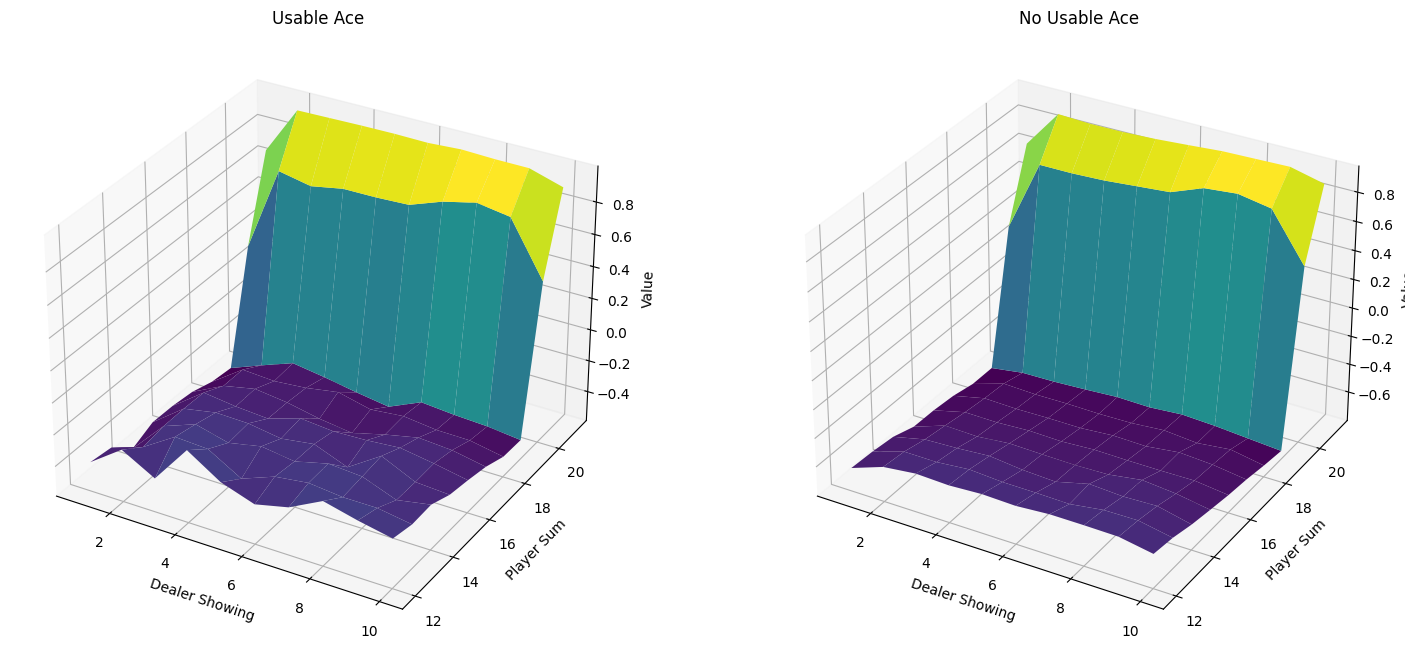

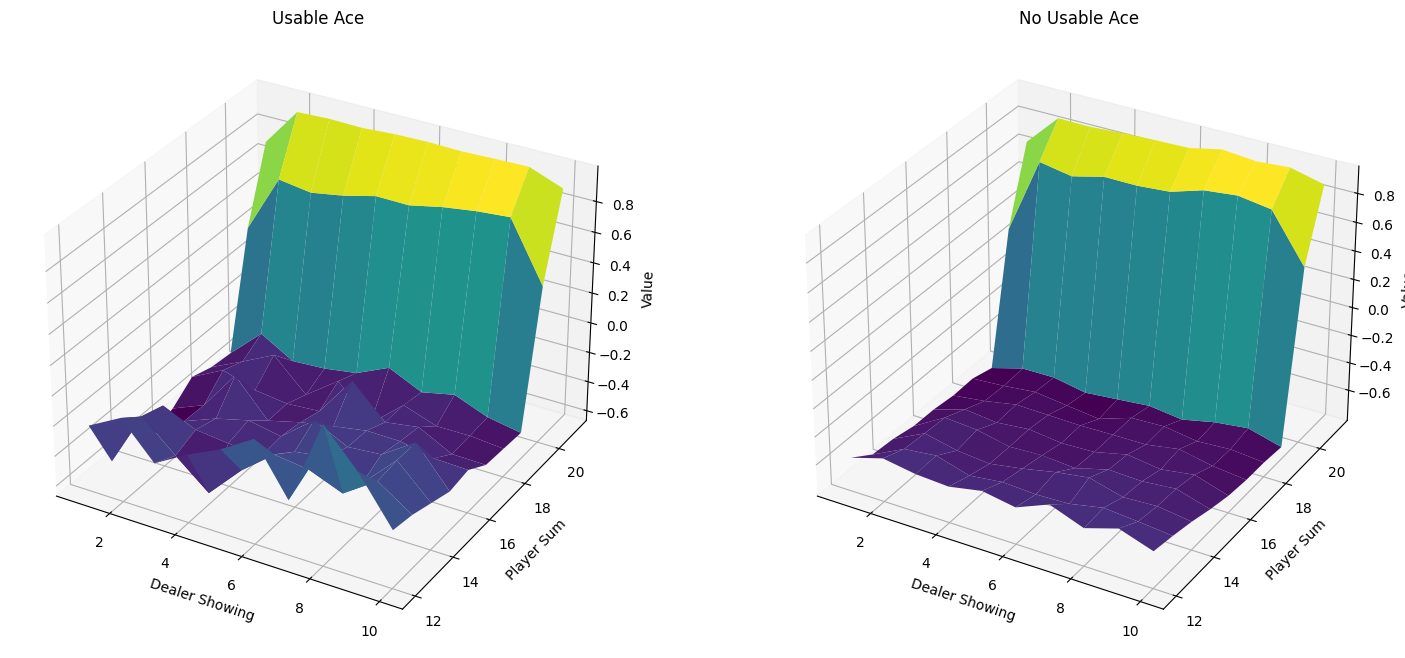

In [55]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot_blackjack_values(V):
    def get_value(V, usable_ace):
        return np.array([[V.get((player, dealer, usable_ace), 0) for dealer in range(1, 11)] for player in range(12, 22)])

    X, Y = np.meshgrid(range(1, 11), range(12, 22))
    Z_usable_ace = get_value(V, True)
    Z_no_usable_ace = get_value(V, False)

    fig = plt.figure(figsize=(18, 8))

    ax = fig.add_subplot(121, projection='3d')
    ax.plot_surface(X, Y, Z_usable_ace, cmap='viridis')
    ax.set_xlabel('Dealer Showing')
    ax.set_ylabel('Player Sum')
    ax.set_zlabel('Value')
    ax.set_title('Usable Ace')

    ax = fig.add_subplot(122, projection='3d')
    ax.plot_surface(X, Y, Z_no_usable_ace, cmap='viridis')
    ax.set_xlabel('Dealer Showing')
    ax.set_ylabel('Player Sum')
    ax.set_zlabel('Value')
    ax.set_title('No Usable Ace')

    plt.show()

plot_blackjack_values(V)
plot_blackjack_values(V_100)

In [56]:
Q, policy_function = on_policy_mc_control_es(env, num_episodes=500000, gamma=1.0)

Episode: 100%|██████████| 500000/500000 [05:43<00:00, 1454.66it/s]


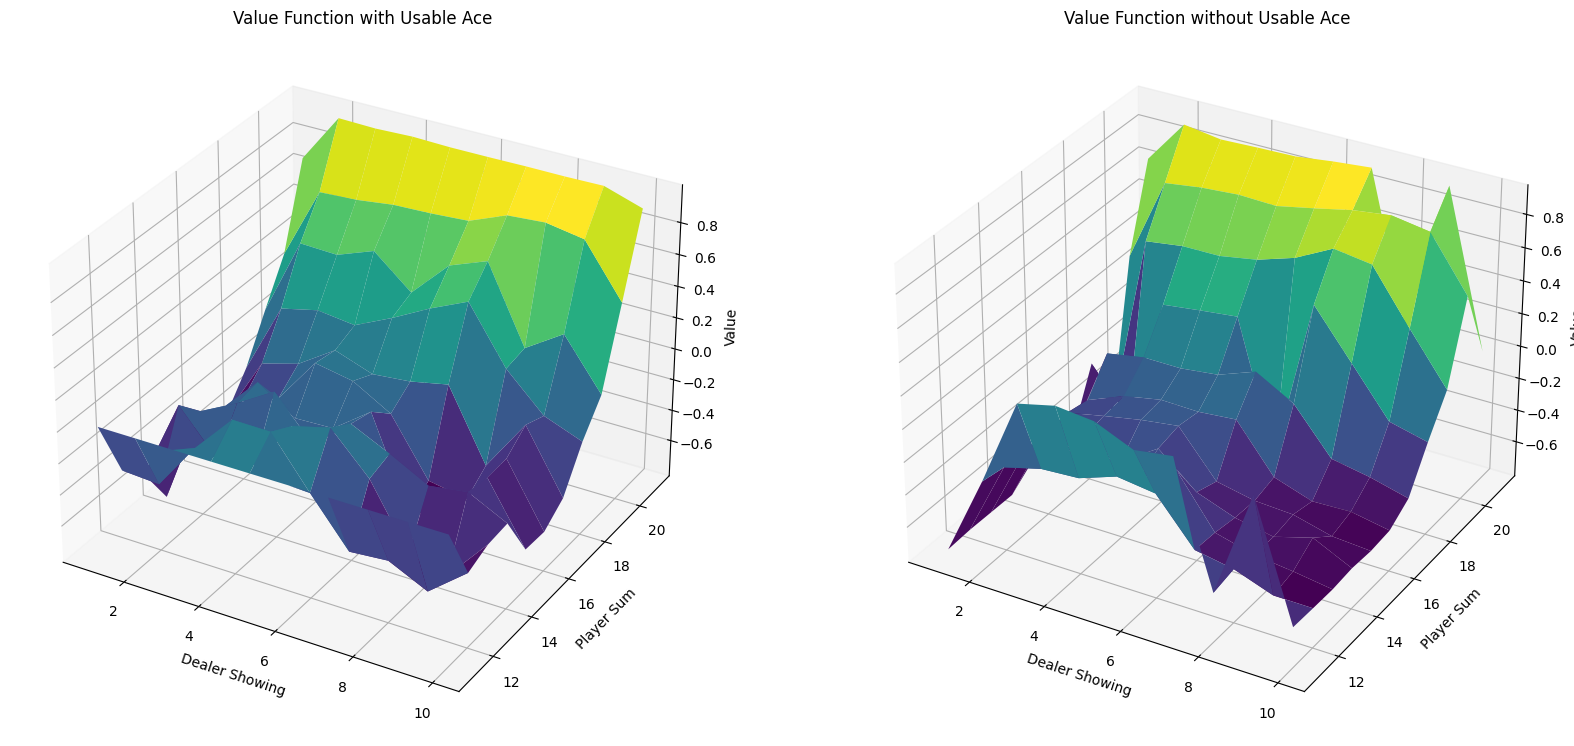

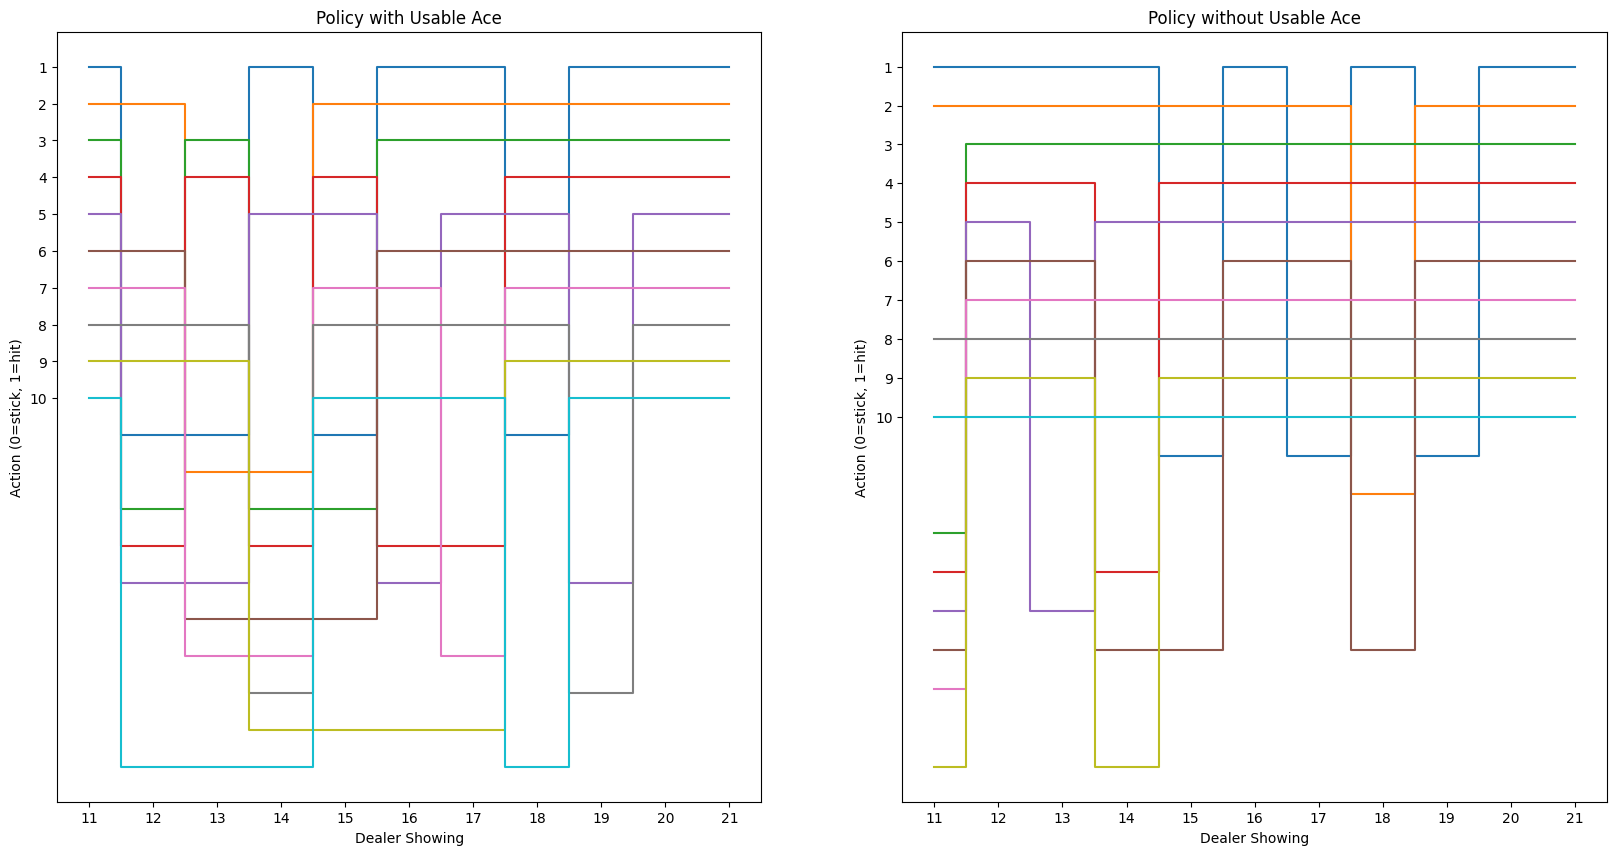

In [57]:
def plot_blackjack_forq(Q):
    def get_Z(x, y, usable_ace):
        # Get the value for the state-action pair with the highest value
        return np.max(Q.get((y, x, usable_ace), np.zeros(2)))

    def get_policy(x, y, usable_ace):
        # Get the action (0 or 1) that has the highest value for the state
        return np.argmax(Q.get((y, x, usable_ace), np.zeros(2)))

    player_sum_range = np.arange(11, 22)
    dealer_showing_range = np.arange(1, 11)

    # Value function plots
    fig = plt.figure(figsize=(20, 10))
    X, Y = np.meshgrid(dealer_showing_range, player_sum_range)

    # Plot the value function for usable ace
    ax1 = fig.add_subplot(121, projection='3d')
    Z_value_usable_ace = np.array([[get_Z(dealer, player, True) for dealer in dealer_showing_range] for player in player_sum_range])
    ax1.plot_surface(X, Y, Z_value_usable_ace, cmap='viridis')
    ax1.set_xlabel('Dealer Showing')
    ax1.set_ylabel('Player Sum')
    ax1.set_zlabel('Value')
    ax1.set_title('Value Function with Usable Ace')

    # Plot the value function for no usable ace
    ax2 = fig.add_subplot(122, projection='3d')
    Z_value_no_usable_ace = np.array([[get_Z(dealer, player, False) for dealer in dealer_showing_range] for player in player_sum_range])
    ax2.plot_surface(X, Y, Z_value_no_usable_ace, cmap='viridis')
    ax2.set_xlabel('Dealer Showing')
    ax2.set_ylabel('Player Sum')
    ax2.set_zlabel('Value')
    ax2.set_title('Value Function without Usable Ace')

    plt.show()

    # Policy plots
    fig, axes = plt.subplots(1, 2, figsize=(20, 10))

    for i, usable_ace in enumerate([True, False]):
        Z_policy = np.array([[get_policy(dealer, player, usable_ace) for dealer in dealer_showing_range] for player in player_sum_range])
        ax = axes[i]

        # Plot the policy using step function
        for dealer in dealer_showing_range:
            ax.step(player_sum_range, Z_policy[:, dealer - 1] + (dealer - 1) * 0.1, where='mid')  # Offset lines for visibility

        ax.set_title(f'Policy {"with" if usable_ace else "without"} Usable Ace')
        ax.set_xlabel('Dealer Showing')
        ax.set_ylabel('Action (0=stick, 1=hit)')
        ax.set_yticks(np.arange(0, len(dealer_showing_range) * 0.1, 0.1), labels=np.arange(1, 11))
        ax.set_xticks(player_sum_range)
        ax.invert_yaxis()  # Flip the y-axis so that 'hit' is at the bottom


    plt.show()

# Use the updated function with the Q-value dictionary and the policy function
plot_blackjack_forq(Q)


4)

In [79]:
env = FourRoomsEnv(goal_pos=(10, 10))

In [82]:
from collections import defaultdict
import numpy as np
from tqdm.notebook import tqdm  # Use tqdm.notebook in Colab for better progress bar integration

def on_policy_mc_control_epsilon_soft(env, num_episodes, gamma, epsilon):
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    returns = defaultdict(list)
    policy = lambda observation: np.random.choice(np.arange(env.action_space.n), p=get_policy_action_prob(Q, observation, epsilon, env.action_space.n))

    for episode in tqdm(range(num_episodes), desc='Episodes'):
        # Generate an episode
        # Following the epsilon-soft policy
        episode = []
        state = env.reset()
        for _ in range(459):  # Use your step limit here
            action = policy(state)
            next_state, reward, done, _ = env.step(action)
            episode.append((state, action, reward))
            if done:
                break
            state = next_state

        # Update Q-values
        G = 0
        for state, action, reward in reversed(episode):
            G = gamma * G + reward
            # Assuming every visit MC control
            returns[(state, action)].append(G)
            Q[state][action] = np.mean(returns[(state, action)])

    return Q, policy

def get_policy_action_prob(Q, observation, epsilon, nA):
    """Obtains the policy's action probabilities."""
    A = np.ones(nA, dtype=float) * epsilon / nA
    best_action = np.argmax(Q[observation])
    A[best_action] += (1.0 - epsilon)
    return A


In [83]:
num_episodes = 1000
gamma = 0.99
epsilon = 0.1

Q, policy = on_policy_mc_control_epsilon_soft(env, num_episodes, gamma, epsilon)


Episodes:   0%|          | 0/1000 [00:00<?, ?it/s]

In [85]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm  # Using the standard tqdm for CLI environments

def run_trials_and_plot(env, num_episodes, gamma, epsilon, trials):
    trial_returns = np.zeros((trials, num_episodes))

    for trial in tqdm(range(trials), desc=f"Running for epsilon = {epsilon}"):
        _, returns = on_policy_mc_control_epsilon_soft(env, num_episodes, gamma, epsilon)
        trial_returns[trial] = returns

    # Calculate the mean and the confidence interval
    mean_returns = np.mean(trial_returns, axis=0)
    sem = np.std(trial_returns, axis=0) / np.sqrt(trials)  # Standard Error of the Mean
    ci = 1.96 * sem  # 95% Confidence Interval

    # Plotting
    plt.fill_between(range(num_episodes), mean_returns - ci, mean_returns + ci, alpha=0.1)
    plt.plot(mean_returns, label=f'epsilon = {epsilon}')

# Set parameters
num_episodes = 5000
gamma = 0.99
epsilon = 0.01  # Focusing on epsilon = 0.01
trials = 5

# Initialize your FourRoomsEnv
env = FourRoomsEnv(goal_pos=(10, 10))

# Plot setup
plt.figure(figsize=(12, 8))
# Run trials and plot for epsilon = 0.01
run_trials_and_plot(env, num_episodes, gamma, epsilon, trials)

# Final plot adjustments
plt.xlabel('Episodes')
plt.ylabel('Average Discounted Return')
plt.title('Learning Curve for Epsilon = 0.01')
plt.legend()
plt.show()



Running for epsilon = 0.01:   0%|          | 0/5 [23:45<?, ?it/s]


KeyboardInterrupt: 

<Figure size 1200x800 with 0 Axes>

4c)
In reinforcement learning, the setting of epsilon = 0 in an epsilon-soft policy corresponds to a greedy policy, where the agent always selects the action that it currently believes to be the best based on its action-value function Q. This means that the agent does not explore the environment; it only exploits the knowledge it already has.

When you use Monte-Carlo with Exploring Starts (MCES) and a greedy policy (epsilon = 0), the initial state and action for each episode are determined randomly. This ensures that all state-action pairs have a non-zero probability of being selected at the start of the episode, which allows the agent to explore and learn about the value of these state-action pairs over time.

Without exploring starts, a greedy policy (epsilon = 0) would never explore actions that it did not already estimate to be the best. This could lead to suboptimal learning for several reasons:

1. **Lack of Exploration**: The agent can get stuck in a suboptimal policy if it never explores actions that could potentially lead to higher returns. This is particularly problematic early in learning when the action-value function Q is not yet accurate.

2. **Convergence to Suboptimal Policy**: If the agent starts off with poor initial estimates or if the initial policy is suboptimal, without exploration, it has no mechanism to improve since it will never try anything different.

3. **Dependence on Initial Conditions**: The final policy learned by the agent would heavily depend on the initial values of Q and the initial policy. If these are not representative of the true value function, the agent may not converge to the optimal policy.

4. **State-Action Space Coverage**: Without exploring starts or any form of exploration, many state-action pairs might never be visited, leaving their value estimates as initialized, which could be far from their true value.

The results of using epsilon = 0 without exploring starts can demonstrate the importance of exploration for learning an optimal policy. If the learning curves for epsilon = 0 show poor performance compared to higher values of epsilon, it suggests that the agent is not exploring enough to find a better policy and is likely stuck in a suboptimal policy. This underlines the importance of exploring starts in MCES as a mechanism to ensure sufficient exploration when the policy is greedy.

In summary, the MCES method with epsilon = 0 and without exploring starts can serve as a cautionary example that highlights the importance of exploration in reinforcement learning, especially in environments where the optimal policy cannot be learned through exploitation alone.

In [87]:
import numpy as np

def track0():
    return np.array([
        [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3],
        [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3],
        [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1]
      ], dtype=np.int32)

def track1():
    return np.array([
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1]
      ], dtype=np.int32)


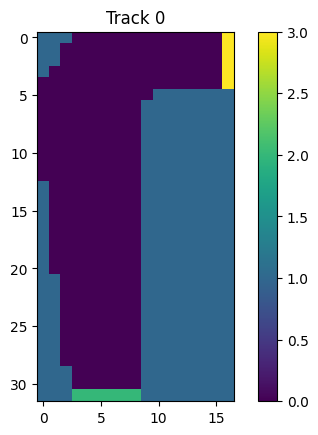

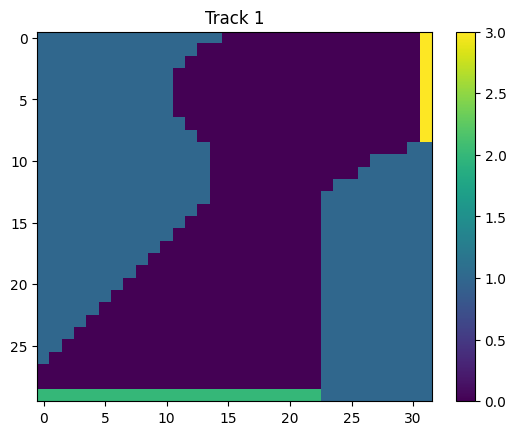

In [88]:
# Display track0
plt.imshow(track0(), cmap='viridis')
plt.title('Track 0')
plt.colorbar()
plt.show()

# Display track1
plt.imshow(track1(), cmap='viridis')
plt.title('Track 1')
plt.colorbar()
plt.show()